# CSCI 3202 Spring 2018 - Friday 20 April

# In-class notebook: Reinforcement learnin'

<a id='top'></a>

<br>

* You will **not** submit this to Moodle. But you may find the implementation of a simple active reinforcement learning technique to be a useful starting point for a particular problem on the practicum.
* Even though you may be developing some key codes in groups here, it is expected any codes you turn in on the practicum **are entirely your own**.  

---

Before we begin, let's load a few packages that we might find useful.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from collections import defaultdict

---

<img src='https://www.explainxkcd.com/wiki/images/9/9a/computers_vs_humans.png' style="width: 500px;"/>

## N-armed bandit

As discussed in class, the N-armed bandit describes the following problem. There is a gambler ("agent") who has the option to play one of N slot machines. The agent can switch between machines, but of course would like to play the one with the highest probability of winning. Alas, these probabilities are unknown... ***for now!***

### Learning the probabilities for each of the bandit's N arms

Initialize a dictionary for keeping track of our best estimates of each lever's value, and the number of times we have pulled each lever.  We should also leave our code general to see how the number of options (levers to pull) affects how quickly we can learn.

In [5]:
N = 3
actions = list(range(N))
Q = defaultdict(float)
Nsa = defaultdict(int)
Nwin = defaultdict(int)
print(actions)

[0, 1, 2]


In general, we will need a policy for each state, which could be initialized as a random policy:
```
policy = {s : random action for s in states}
```

But here we just want something to return a random action.  Finish this function to pick a random action for us.

In [18]:
def random_policy(actions):
    '''Return a random action (uniform random!)'''
    
    policy = np.random.choice(actions)
    return policy

We need to represent the result of the action of pulling a given lever.  So we need probabilities for each.  Let's use the ones from class for now, and write a function to return a win (+1) or loss (+0) with those probabilities, based on which lever we pull (`action`):

In [47]:
p_levers = [0.3, 0.5, 0.8]

def result(action, p_levers):
    ''' Return a win (+1) with probability p_levers for the 
    lever pulled, and a loss (+0) with probability 1-p_levers[action].
    action = which lever you pull (index within p_levers)
    '''
    p_win = p_levers[action]
    return np.random.choice([0,1], p = [1-p_win, p_win])
    

**First, consider the following:**  What is the best you could hope to do, on average, if you *knew* what the probabilities of winning are on any given slot machine?  That is, what is you knew `p_levers`?

We could win 80% of the time.

<br>

### Training

Let's run 10 training episodes and see what we get. First, set the random seed so at least for the first step here, we will all be on the same page.

For now, save the results of each training episode in a list, along with the reward from each episode.

In [41]:
np.random.seed(3202)

levers = []
rewards = []
for k in range(1000):
    choice = random_policy(actions)        # pick a lever to pull
    resultant = result(choice, p_levers)   # what is the result of that pull?
    levers.append(choice)
    rewards.append(resultant)

**The important question:** What are our estimates of the expected utility for each lever?  That is, what are our best estimates of $Q(0)$, $Q(1)$ and $Q(2)$ after this brief training period?

Note that we can obtain the total number of times lever 0 was pulled as follows:

In [42]:
Nsa[0] = sum([l==0 for l in levers])
print(Nsa)

defaultdict(<class 'int'>, {0: 350})


and we can get the number of times lever 0 resulted in a win like so:

In [43]:
Nwin[0] = sum([l==0 and r==1 for l,r in zip(levers,rewards)])
print(Nwin[0])

99


which makes our best guess for the expected utility of lever 0:

In [48]:
Q[0] = Nwin[0]/Nsa[0] #our best guess for expected utility of our choices
print(Q[0])

0.282857142857


Update the counters `Nwin` and `Nsa`, and calculate our best estimates of `Q` for levers 1 and 2 as well.  How close are these to the actual values?  Should we continue to **explore** or start **exploiting** at this point?

In [49]:
for s in actions:
    Nsa[s] = sum([l == s for l in levers])
    Nwin[s] = sum([l == s and r == l for l,r in zip(levers, rewards)])
    Q[s] = Nwin[s]/Nsa[s]

In [53]:
'''
    Nwin[1] = sum([l==1 and r == 1 for l,r in zip(levers, rewards)])
    Nwin[2] = sum([l==2 and r == 1 for l,r in zip(levers, rewards)])

    Nsa[1] = sum([l==1 for l in levers])
    Nsa[2] = sum([l==2 for l in levers])

    Q[1] = Nwin[1]/Nsa[1]
    Q[2] = Nwin[2]/Nsa[2]
'''

'\n    Nwin[1] = sum([l==1 and r == 1 for l,r in zip(levers, rewards)])\n    Nwin[2] = sum([l==2 and r == 1 for l,r in zip(levers, rewards)])\n\n    Nsa[1] = sum([l==1 for l in levers])\n    Nsa[2] = sum([l==2 for l in levers])\n\n    Q[1] = Nwin[1]/Nsa[1]\n    Q[2] = Nwin[2]/Nsa[2]\n'

#### Let's actively learn!

First, we need to include an online estimate of `Q` for each state, that updates `Nsa`, `Nwin` and `Q` as the training progresses, as opposed to after the fact. That is, we need to calculate these things **within** the 'for' loop as opposed to outside of it.  Make sure that you again set the random seed the same as the first time you did this training, so you can check that the results are the same with your new online updating of `Q`.

**Potentially useful fact:**  in Python, `x[-1]` returns the *last* item of a list `x`.

In [55]:
np.random.seed(3202)

Q = defaultdict(float)       # re-initializing each time we train
Nsa = defaultdict(int)
Nwin = defaultdict(int)
levers = []
rewards = []

for k in range(10):
    levers.append(random_policy(actions))          # pick a lever to pull
    rewards.append(result(levers[-1], p_levers))   # what is the result of that pull?
    Nsa[levers[-1]] += 1                           # update Nsa
    Nwin[levers[-1]] += rewards[-1]                # update Nwin
    Q[levers[-1]] = Nwin[levers[-1]] / Nsa[levers[-1]]   # update Q
    
print(Q)

defaultdict(<class 'float'>, {0: 0.0, 2: 0.8571428571428571, 1: 0.5})


#### Subroutinization for training sampling

Before we go any further, we really ought to subroutinize that training loop above.  We also should add some measure of how well we are doing.  So we can (1) track the rewards we've gotten, and (2) use the mean of the last 100 rewards as a measure of how good our strategy is. And, after the 100th training episode, we can keep track of this measure as the training progresses; if it increases, then we are learning! And that's nice.

The inputs to our training function are the number of training episodes to run, the available `actions` and `p_levers`, and the outputs should be the counters `Nsa` and `Nwin`, the latest utility estimates `Q` and our time series of mean rewards, `avg_reward`. Finish off this function below.

In [56]:
def run_training(n_train, actions, p_levers):
    
    assert n_train >= 100, 'Need at least 100 training episodes'
    
    Q = defaultdict(float)       # re-initializing
    Nsa = defaultdict(int)
    Nwin = defaultdict(int)
    levers = []                  # not actually necessary to keep track of
    rewards = []                 # to calculate running average reward
    avg_reward = []              # running average reward
    
    for k in range(n_train):
        levers.append(random_policy(actions))          # pick a lever to pull
        rewards.append(result(levers[-1], p_levers))   # what is the result of that pull?
        Nsa[levers[-1]] += 1                           # update Nsa
        Nwin[levers[-1]] += rewards[-1]                # update Nwin
        Q[levers[-1]] = Nwin[levers[-1]] / Nsa[levers[-1]]   # update Q
        
        #Here is where the Q-Learning, or the TD or ADP equations would go
        # If we are beyond the 100th training episode,
        # then update the running average reward
        if k >= 100:
            avg_reward.append(np.mean(rewards[-100:]))

    return Nsa, Nwin, Q, avg_reward

Run the training!

In [57]:
n_train = 10000
Nsa, Nwin, Q, avg_reward = run_training(n_train, actions, p_levers)

**A question of interest:** What is the expected reward of any given trial?

**[A]** You can calculate this using the Law of Total Probability or estimate by running the above training simulation for many iterations and making an estimate of the probability of winning, regardless of lever pulled. Do that now!

In [58]:
print('Expected reward is: {}'.format(sum(Nwin.values())/n_train))

Expected reward is: 0.5302


**[B]** Let's also make a plot of the running average for mean reward as the training progresses.

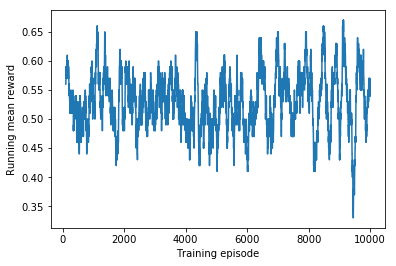

In [59]:
episodes = list(range(100,100+len(avg_reward)))  # episodes we have output for
plt.plot(episodes, avg_reward)
plt.xlabel('Training episode')
plt.ylabel('Running mean reward')
plt.show()

**Consider**:  how should the number from **A** and the plot from **B** be related?

### $\epsilon$-greedy agent

So far, the agent playing this slot machine game has not been trying to *improve* their strategy based on the estimates of `Q`.  So let's fix that.

Let's implement an $\epsilon$-greedy agent. Below is a function to for selecting an $\epsilon$-greedy action, with a default $\epsilon$ (probability of acting randomly) of 0.1.

In [60]:
def epsilon_greedy_action(actions, Q, epsilon=0.1):
    '''Return a random action or the one with highest utility (so far).
    Also will return a random action if we have not observed anything
    to estimate Q yet.
    '''
    if (np.random.uniform()<=epsilon) or (len(Q)==0):
        action = random_policy(actions)
    else:
        action = max([(p,a) for (a, p) in Q.items()])[1]
    return action

Revise the `run_training` routine ever so slightly so that instead of getting a random action for which lever to pull, the agent chooses an `epsilon_greedy_action`.

In [61]:
def run_smart_training(n_train, actions, p_levers):
    assert n_train >= 100, 'Need at least 100 training episodes'
    
    Q = defaultdict(float)       # re-initializing
    Nsa = defaultdict(int)
    Nwin = defaultdict(int)
    levers = []                  # not actually necessary to keep track of
    rewards = []                 # to calculate running average reward
    avg_reward = []              # running average reward
    
    for k in range(n_train):
        levers.append(epsilon_greedy_action(actions, Q))          # pick a lever to pull
        rewards.append(result(levers[-1], p_levers))   # what is the result of that pull?
        Nsa[levers[-1]] += 1                           # update Nsa
        Nwin[levers[-1]] += rewards[-1]                # update Nwin
        Q[levers[-1]] = Nwin[levers[-1]] / Nsa[levers[-1]]   # update Q
        
        #Here is where the Q-Learning, or the TD or ADP equations would go
        # If we are beyond the 100th training episode,
        # then update the running average reward
        if k >= 100:
            avg_reward.append(np.mean(rewards[-100:]))

    return Nsa, Nwin, Q, avg_reward

Now re-run the training with an $\epsilon$-greedy agent using the constant $\epsilon = 0.1$. Do 10,000 training episodes and report the expected reward. Generate another plot showing the running average reward as training progresses.

Expected reward is: 0.7672


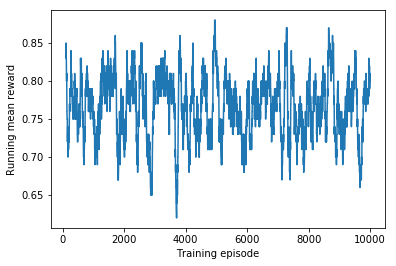

In [62]:
# Run the training
n_train = 10000
Nsa, Nwin, Q, avg_reward = run_smart_training(n_train, actions, p_levers)

# Print the expected reward
print('Expected reward is: {}'.format(sum(Nwin.values())/n_train))

# Make a plot of the running average reward
episodes = list(range(100,100+len(avg_reward)))  # episodes we have output for
plt.plot(episodes, avg_reward)
plt.xlabel('Training episode')
plt.ylabel('Running mean reward')
plt.show()

**Some questions:**

1. How well does our $\epsilon$-greedy agent do?
1. How well theoretically *could* our agent do, if it knew exactly what the probabilities of each lever paying out are?

#### $\epsilon$-decreasing greedy agent

Let's see if we can get closer to that theoretical upper limit, where the agent figures out quickly which lever is the best and starts pulling that one sooner.

To do this, we can implement an $\epsilon$-decreasing agent, where we pick some functional form for $\epsilon$ that decreases as the training progresses.  You may want to play around with different forms of this function, but this fairly simple problem does not require anything too fancy.

We can implement this $\epsilon$-decreasing within the `run_smart_training` function by modifying the `epsilon` argument that is fed into `epsilon_greedy_action`.  Call this version of your training routine `run_smarter_training`, and make the code modifications below.

In [64]:
def run_smarter_training(n_train, actions, p_levers):
    assert n_train >= 100, 'Need at least 100 training episodes'
    
    Q = defaultdict(float)       # re-initializing
    Nsa = defaultdict(int)
    Nwin = defaultdict(int)
    levers = []                  # not actually necessary to keep track of
    rewards = []                 # to calculate running average reward
    avg_reward = []              # running average reward
    epsilon = 0.1
    for k in range(n_train):
        levers.append(epsilon_greedy_action(actions, Q, epsilon))          # pick a lever to pull
        rewards.append(result(levers[-1], p_levers))   # what is the result of that pull?
        Nsa[levers[-1]] += 1                           # update Nsa
        Nwin[levers[-1]] += rewards[-1]                # update Nwin
        Q[levers[-1]] = Nwin[levers[-1]] / Nsa[levers[-1]]   # update Q
        
        #Here is where the Q-Learning, or the TD or ADP equations would go
        # If we are beyond the 100th training episode,
        # then update the running average reward
        epsilon -= 0.01
        if k >= 100:
            avg_reward.append(np.mean(rewards[-100:]))

    return Nsa, Nwin, Q, avg_reward

Now train this new and improved agent!  How well can the $\epsilon$-decreasing agent do, relative to our theoretical upper limit?

Expected reward is: 0.7993


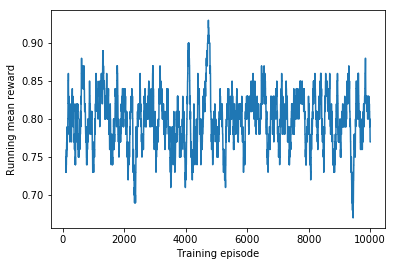

In [65]:
# Run the training
n_train = 10000
Nsa, Nwin, Q, avg_reward = run_smarter_training(n_train, actions, p_levers)

# Print the expected reward
print('Expected reward is: {}'.format(sum(Nwin.values())/n_train))

# Make a plot of the running average reward
episodes = list(range(100,100+len(avg_reward)))  # episodes we have output for
plt.plot(episodes, avg_reward)
plt.xlabel('Training episode')
plt.ylabel('Running mean reward')
plt.show()

### Other ways to make things more complicated

If you've made it this far, there are a couple extra ways in which we can spice things up and make the problem more difficult.

1. Try using more levers.
1. Try incentivizing the agent to explore all of the levers a set number of times (i.e., implement an **exploration function**).
1. Try making it tougher for the agent to tell which lever is better than any others (i.e., make the `p_levers` values closer together).